# Determination of Asteroid Parameters

In **Extension Functionality**, we are asked to show how our solver can determine asteroid parameters that best fit an observed energy deposition curve given a set of incomplete asteroid parameters.

As an example, we take the energy deposition curve inferred for the Chelyabinsk event as the observations, where the energy is given in units of [kilotons of TNT](https://en.wikipedia.org/wiki/TNT_equivalent). In addition, we know that the density is 3300 $\text{kg/m}^3$, entry angle is 18.3 degrees to horizontal, and entry velocity is 19.2 $\text{km/s}$ ([Popova et al., 2013](http://doi.org/10.1126/science.1242642)).

To achieve this, we will use `scipy.optimize` and define a loss function `optimiseFunc` and a parameter optimizer `paramFinder`.

The results below proves that our solver is able to successfully determine the asteroid parameters (asteroid radius and altitude) given density, impact angle and entry velocity which best fit observations from Chelyabinsk event.


## 1. Initialization

- import modules, functions and classes
- load observations from Chelyabinsk event
- initialize an object of the Planet class

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from armageddon import Planet

%matplotlib inline

In [2]:
data_filename = 'resources/ChelyabinskEnergyAltitude.csv'

data = pd.read_csv(data_filename, header=0, names=["h", "dedz"])
data.head()

,h,dedz
0,42.1922,1.07070
1,39.9311,1.09545
2,39.0415,1.10519
3,38.4485,1.23483
4,38.0784,1.85465


In [3]:
# Initialise the Planet class
earth = Planet(atmos_func='tabular')

## 2. Defining Functions

- define a MSE caculator
- define a function returns optimal parameters

In [4]:
def optimiseFunc(x):
    """
    Calculator of MSE given radius and strength.

    Parameters
    ----------
        x : callable (radius, strength)
            Scaled radius and strength. The radius is scaled by 9.0,
            while the strength is scaled by 3e6.

    Returns
    ----------
        loss : float
            Returns the MSE against exact dedz and altitude, scaled by 1e5
    """
    # Solve the atmospheric entry problem for a given set of inputparameters
    result = earth.solve_atmospheric_entry(radius=x[0]*9.0, angle=18.3,
                                           strength=x[1]*3e6, density=3300,
                                           velocity=19.2e3, dt=0.1,
                                           init_altitude=50e3)

    # Calculate energy with the result of the atmospheric entry problem
    energy = earth.calculate_energy(result)

    # Load the evaluations
    h = energy.altitude / 1000  # The unit of h is meter then take scaling
    e = energy.dedz

    # Load the real data
    hdata = data.h.values
    edata = data.dedz.values

    # Get e to have the same timestamps as edata
    func = interp1d(h, e, kind='linear')
    einterp = func(hdata)
    
    loss = np.sqrt(np.sum((einterp - edata)**2)) / len(edata)

    return loss * 1e5

In [5]:
def paramFinder(lossFunc, init_state, bounds, method):
    """
    Calculator of MSE given radius and strength.

    Parameters
    ----------
        lossFunc : callable
            The objective function to be optimized
        init_state : list
            Initial guess
        bounds : sequence
            Bounds on variables
        method : str
            Solver type for optimization


    Returns
    ----------
        best_params : tuple
            Returns the optimzed radius and strength
    """

    sol = minimize(lossFunc, init_state, bounds=bounds,
                   method=method)

    # Scaling
    radius = sol.x[0] * 9
    strength = sol.x[1] * 3e6

    best_params = (radius, strength)

    return best_params

## 3. Optimization Test

- call `paramFinder` to solve the optimization problem
- unpack and present solutions
- run the solver again with the optimzed parameters
- plot actual dedz to altitude and the evaluations
- calculate the MSE of the optimzed parameters

In [6]:
sol = paramFinder(optimiseFunc, [0.1, 0.1], bounds=[(0, 3), (0, 1)],
               method='Nelder-Mead')

In [7]:
radius = sol[0]
strength = sol[1]

print(f'Radius: {radius} \nStrength: {strength}')

Radius: 9.175061817842206 
Strength: 838286.0476887351


In [8]:
result = earth.solve_atmospheric_entry(radius=radius, angle=18.3,
                                       strength=strength, density=3300,
                                       velocity=19.2e3, dt=0.05,
                                       init_altitude=50e3)

energy = earth.calculate_energy(result)

Text(0.5, 0, 'dedz ($Kt . km^{-1}$)')

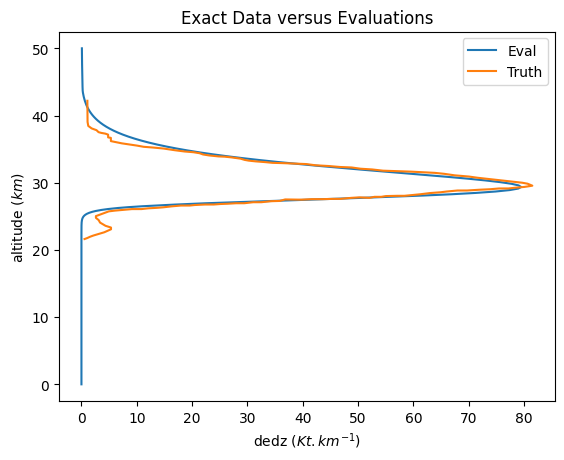

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(energy.dedz, energy.altitude*1e-3, label='Eval')
ax.plot(data.dedz, data.h, label='Truth')
plt.legend()
plt.title('Exact Data versus Evaluations')
plt.ylabel(r'altitude ($km$)')
plt.xlabel(r'dedz ($Kt . km^{-1}$)')

In [10]:
print(f'MSE: ', optimiseFunc([radius/9.0, strength/3e6]))

MSE:  33412.20025787228


Indicated by the graph above, the evaluations produced from the solver with optimal radius and strength fit the energy deposition curve inferred for the Chelyabinsk event visually well. Numerically, the MSE of the radius and strength is around 39423.67.

More tests with varying initial guesses are shown below.

## 4. Additional Optimization Tests

- set initial guess to [0.3, 0.3] and test
- set initial guess to [0.5, 0.5] and test
- set initial guess to [0.7, 0.7] and test
- show results of our approximated

In [11]:
# initial guess set to [0.3, 0.3]
sol = paramFinder(optimiseFunc, [0.3, 0.3], bounds=[(0, 3), (0, 1)],
               method='Nelder-Mead')

radius = sol[0]
strength = sol[1]

print(f'Radius: {radius} \nStrength: {strength}')
print(f'MSE: ', optimiseFunc([radius/9.0, strength/3e6]))

Radius: 9.175087130914072 
Strength: 849663.9501785224
MSE:  33418.999637933965


In [12]:
# initial guess set to [0.5, 0.5]
sol = paramFinder(optimiseFunc, [0.5, 0.5], bounds=[(0, 3), (0, 1)],
               method='Nelder-Mead')

radius = sol[0]
strength = sol[1]

print(f'Radius: {radius} \nStrength: {strength}')
print(f'MSE: ', optimiseFunc([radius/9.0, strength/3e6]))

Radius: 9.175062318167065 
Strength: 838199.6462385793
MSE:  33412.20020832377


In [13]:
# initial guess set to [0.7, 0.7]
sol = paramFinder(optimiseFunc, [0.7, 0.7], bounds=[(0, 3), (0, 1)],
               method='Nelder-Mead')

radius = sol[0]
strength = sol[1]

print(f'Radius: {radius} \nStrength: {strength}')
print(f'MSE: ', optimiseFunc([radius/9.0, strength/3e6]))

Radius: 9.123032892064934 
Strength: 867669.9194537471
MSE:  33868.03983479483


Firstly, even if we change the inital guesses, these results are almost identical. Therefore, we can conclude that our method to determine asteroid parameters is stable and valid. 

Secondly, according to these tests, given that the density is 3300 $\text{kg/m}^3$, impact angle is 18.3 degrees to horizontal, and entry velocity is 19.2 $\text{km/s}$, the missing parameters which best fit the Chelyabinsk oberservations are approximately:

$$
Radius: 9.123 m\\
Strength: 867669.919 Pa,
$$

And the results will be the following.

MSE:  33868.03983479483


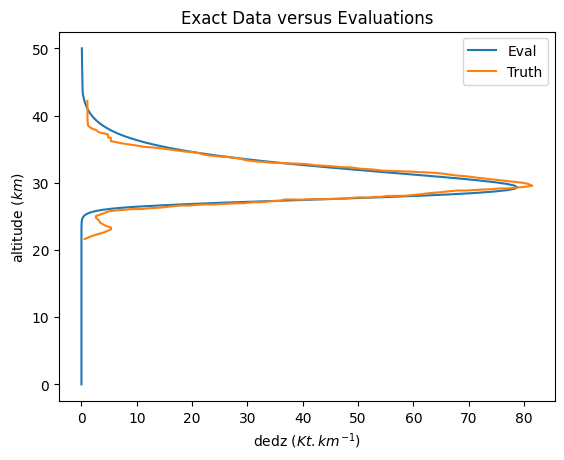

In [14]:
# radius = 9.2468
# strength = 743190.43
# radius = 9.1230
# strength = 867669.919

result = earth.solve_atmospheric_entry(radius=radius, angle=18.3,
                                       strength=strength, density=3300,
                                       velocity=19.2e3, dt=0.05,
                                       init_altitude=50e3)

energy = earth.calculate_energy(result)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(energy.dedz, energy.altitude*1e-3, label='Eval')
ax.plot(data.dedz, data.h, label='Truth')
plt.legend()
plt.title('Exact Data versus Evaluations')
plt.ylabel(r'altitude ($km$)')
plt.xlabel(r'dedz ($Kt . km^{-1}$)')

print(f'MSE: ', optimiseFunc([radius/9.0, strength/3e6]))

And the outcomes show a great fit both visually and numerically.